In [1]:
# t - test analysis to find significant features of a specific road segment (or municipality) compared to all other road segments (or municipalities).
# script inputs: input_type, input_value, filter1_column, filter1_value, filter2_column, filter2_value, hard_only
# for example, this notebook analyses the road segment : "MECHLAF LAKIA - TZOMET ARAD". 
# the input_type is "road_segment_name", the input_value is the name of the road segment, and the filter is road_type_hebrew = LO IRONIT, LO BETZOME
# occurrences of demographic segments are counted by the number of casualties, while the occurrences of accident segments are counted by the number of accidents

In [2]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np



sample_size = 10000000 # choose 1000 to reduce runtime
raw_data = pd.read_csv("C://Users//user//PycharmProjects//anyway//data//views_2019//involved_markers_hebrew.csv",nrows=sample_size,low_memory=False)


In [15]:
input_type = 'road_segment_name' #place type: road1, accident_yishuv_name, 'road_segment_name',street1_hebrew
input_value = 'מחלף לקייה - צומת ערד'  #place name from news flash
filter1_column = 'road_type_hebrew' #(optional -  filter type, if not relevant write None)
filter1_value = 'לא-עירונית לא בצומת'#(optional -  filter value, if not relevant write None)
filter2_column = None   #(opional - another filter type, if not relevant write None)
filter2_value = None #(optional - another filter value, if not relevant write None)
hard_only = False# Only hard accidents?

#segments to analyze (everything is optional, remove segments that create unuseful output
demographic_segments = [
    'is_male',
    'is_over_70',
    'is_under_14',
   # 'is_pedestrian'
   # ,'is_jew'
]
accident_segments = [
    'is_daytime',
    'is_summer',
    'is_weekend',
    'is_head-on',
    'is_roll-over',
    'is_hard',
    'is_deadly',
    'is_animal',
    'is_truck',
    'is_electric'
    
]


In [16]:
#data cleaning 
def clean_data(data):
    data['is_male'] = data['sex'].replace(0,np.nan).replace(2,0) #male = 1, female = 0, remove unknown
    data['is_over_70'] = data['age_group'].replace(99,np.nan) #remove unknown
    data['is_over_70'] = np.where(data['is_over_70']>14,1,0) #above code 14 is over 70
    data['is_under_14'] = data['age_group'].replace(99,np.nan) #remove unknown
    data['is_under_14'] = np.where(data['is_under_14']<4,1,0) #under code 4 is over 14
    data['is_weekend'] = np.where(data['day_in_week']>5,1,0) #Fri and Sat are weekends
    data['is_jew'] = data['population_type'].replace([2,3,4,''],0)#convert non jews to 0
    data['is_daytime'] = data['day_night'].replace(5,0)#convert night (5) to 0
    data['is_pedestrian'] = data['injured_type'].replace([2,3,4,5,6,7,8,9],0) #convert non pedestrian to 0, pedestrian to 1
    data['is_summer'] = data['accident_month'].replace([10,11,12,1,2,3],0).replace([4,5,6,7,8,9],1) #convert winter to 0 ,summer to 1
    data['is_head-on'] = np.where(data['accident_type']==5,1,0) # type 5 is headon haziti
    data['is_hard'] = data['accident_severity'].replace(3,0).replace([1,2],1) # hard accidents will get 1
    data['is_deadly'] = data['accident_severity'].replace([3,2],0)# deadly accidents will get 1
    data['is_driver'] = data['injured_type'].replace([2,3,4,5,6,7,8,9],0) #convert non pedestrian to 0, pedestrian to 1
    data['is_roll-over'] = np.where(data['accident_type']==10,1,0)# type 10 is roll-over
    data['is_motorcycle'] = np.where((data['vehicle_vehicle_type']>7) & (data['vehicle_vehicle_type']<11),1,0) # numbers that represent motorcycle
    data['is_truck'] = np.where((data['vehicle_vehicle_type']>3) & (data['vehicle_vehicle_type']<8),1,0) # numbers that represent truck
    data['is_electric'] = np.where((data['vehicle_vehicle_type']>20) & (data['vehicle_vehicle_type']<24),1,0) # numbers that represent truck
    data['full_street1_hebrew'] = data['accident_yishuv_name'] +"_" + data['street1_hebrew'] # new column of city+street na
    data['is_animal'] = np.where(data['accident_type']==19,1,0) # type 19 is animal crash


    length_before_removing_null = data.shape[0]
    data = data[data[input_type].notnull()] # filter for not null of input type (type of place)
    removed = length_before_removing_null-data.shape[0]
    removed_percent = removed/length_before_removing_null
    print("Removed %d rows - %.3f that do not contain %s"%(removed, removed_percent,input_type))
    data = data[data['involved_type'] != 1] # only NIFGAIM, not drivers
    
    value_dict = {} #set real values for the binary values in segments
    value_dict['is_male'] = ('female','male')
    value_dict['is_over_70'] = ('מתחת_70','מעל_70')
    value_dict['is_under_14'] = ('מעל_14','מתחת_14')
    value_dict['is_weekend'] = ('weekday','weekend')
    value_dict['is_jew'] = ('non_jew','jew')
    value_dict['is_daytime'] = ('night-time','day-time')
    value_dict['is_pedestrian'] = ('not_pedestrian','pedestrian')
    value_dict['is_summer'] = ('winter','summer')
    value_dict['is_head-on'] = ('not head-on','head-on')
    value_dict['is_roll-over'] = ('not roll-over','roll-over')
    value_dict['is_hard'] = ('not hard accident','hard accident')
    value_dict['is_deadly'] = ('not deadly','deadly accident')
    value_dict['is_driver'] = ('not driver','driver')
    value_dict['is_animal'] = ('לא_פגיעה_בבעל_חיים','פגיעה_בבעל_חיים')
    value_dict['is_motorcycle'] = ('לא_אופנוע','אופנוע')
    value_dict['is_truck'] = ('לא_משאית','משאית')
    value_dict['is_electric'] = ('לא_דו_גלגלי_חשמלי','דו_גלגלי_חשמלי')
    
    if filter1_value is not None:
        data = data[data[filter1_column] == filter1_value] # apply filter 1
    if filter2_value is not None:
        data = data[data[filter2_column] == filter2_value] # apply filter 2
    if hard_only:
        data = data[data['accident_severity']<3]  # apply filter of severity. under 3 its serious injury and death
    return data,value_dict

acc_data, value_dict = clean_data(raw_data)


Removed 1420865 rows - 0.749 that do not contain road_segment_name


In [23]:
def analyse_segment(data,i):
    message = None
    result = None  
    results_touple = None
    filtered_acc_data = data[data[input_type]==input_value] #table of only the value chosen (road number 90 for example)
    all_rows = data[i].dropna().reset_index(drop=True) #only the segment column
    filtered_rows = data[acc_data[input_type]==input_value][i].dropna() #only the segment column  - filtered
    s,p = ttest_ind(all_rows,filtered_rows,nan_policy='omit') # ttest for the segment columns
    if p > 0.1 or np.isnan(p):
        return message,result,results_touple
    percent_filtered = 'percent_of_filtered' #create column name for percent in segmented data
    count_filtered = "count_of_filtered"#create column name for count in segmented data
    acc_data_tmp = data.groupby(i).size().reset_index().rename(columns={0: "count"}) #create groupby table
    acc_data_tmp['percent'] = acc_data_tmp["count"]/acc_data_tmp["count"].sum() # create percent column
    acc_data_tmp['percent'] = acc_data_tmp['percent'].astype(float).map(lambda n: '{:.0%}'.format(n)) #convert to percent format
    filtered_acc_data_tmp =  filtered_acc_data.groupby(i).size().reset_index().rename(columns={0: count_filtered})
    filtered_acc_data_tmp[percent_filtered] = \
        filtered_acc_data_tmp[count_filtered]/filtered_acc_data_tmp[count_filtered].sum()
    filtered_acc_data_tmp[percent_filtered] = filtered_acc_data_tmp[percent_filtered].astype(float).map(lambda n: '{:.0%}'.format(n))
    final_table = pd.concat([acc_data_tmp, filtered_acc_data_tmp.drop(i,axis = 1)], axis=1, sort=False)
    if final_table.isnull().values.any():
        return message,result,results_touple
    for j in range(len(final_table)):
        filtered_count = final_table.loc[j,count_filtered]
        filtered_percent = float(final_table.loc[j,percent_filtered].strip('%'))/100
        original_percent = float(final_table.loc[j,'percent'].strip('%'))/100
        if original_percent == 0:
            break 
        if (filtered_percent - original_percent > 0.10 or filtered_percent/original_percent > 1.3) and filtered_percent > 0.04 and filtered_count > 20: #if the difference is significant  - tell me
            message = "The percentage of %s is higher than average in %s (%s vs. %s)"\
                      %(value_dict[i][j],'{:.0%}'.format(filtered_percent/original_percent-1),'{:.0%}'.format(filtered_percent),'{:.0%}'.format(original_percent))
            result = final_table
            results_touple = (i,j)
           
    return message,result,results_touple
    

In [24]:
def create_time_graph(data,results_touple,type):
    from matplotlib import pyplot as plt
    from bidi.algorithm import get_display
  #  data = data[data['accident_severity']<3]  # apply filter of severity. under 3 its serious injury and death
    filtered_data = data[(data[input_type]==input_value) & (data[results_touple[0]] == results_touple[1])].groupby('accident_year').size().reset_index()\
        .rename(columns={0: "count"}) # create table of accidents by time - filtered for certain road_segment
    fig = plt.figure()
    filtered_data.plot(x='accident_year',y='count',kind="line",cmap = 'Set1')
    for x,y in zip(filtered_data['accident_year'],filtered_data['count']):
        label = y
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center',# horizontal alignment can be left, right or center
                     )#fontsize = 10)
        
    plt.title("%s by year - %s = %d"%(type,results_touple[0],results_touple[1]))
    plt.show()
   


********General*******

Checking significance for accidents when {road_segment_name} is {מחלף לקייה - צומת ערד}
Filters:
road_type_hebrew = לא-עירונית לא בצומת

*******Significant segments - demographics*******

*******************************************************************************************
The percentage of מתחת_14 is higher than average in 33% (12% vs. 9%)


<Figure size 432x288 with 0 Axes>

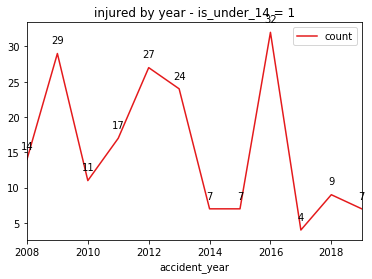


*******Significant segments - accident features*******



*******************************************************************************************
The percentage of weekend is higher than average in 45% (29% vs. 20%)


c:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


<Figure size 432x288 with 0 Axes>

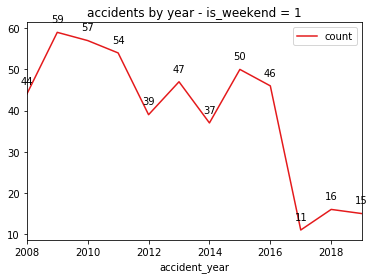

*******************************************************************************************
The percentage of head-on is higher than average in 100% (6% vs. 3%)


<Figure size 432x288 with 0 Axes>

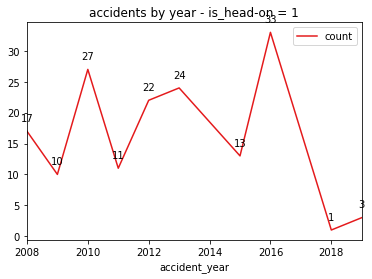

*******************************************************************************************
The percentage of roll-over is higher than average in 125% (9% vs. 4%)


<Figure size 432x288 with 0 Axes>

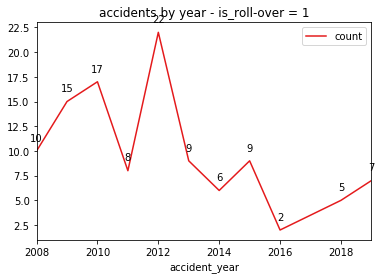

*******************************************************************************************
The percentage of hard accident is higher than average in 100% (12% vs. 6%)


<Figure size 432x288 with 0 Axes>

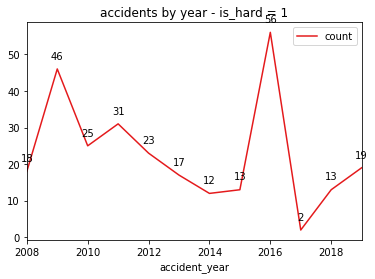

*******************************************************************************************
The percentage of deadly accident is higher than average in 200% (6% vs. 2%)


<Figure size 432x288 with 0 Axes>

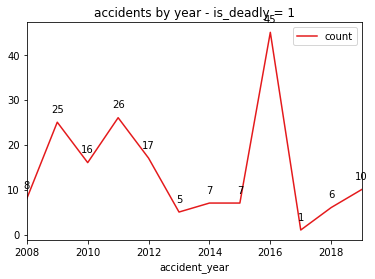


*******Significant segments in details*******

 is_under_14   count percent  count_of_filtered percent_of_filtered
           0  202997     91%               1389                 88%
           1   19158      9%                188                 12%
 is_weekend  count percent  count_of_filtered percent_of_filtered
          0  90091     80%                482                 71%
          1  22572     20%                198                 29%
 is_head-on   count percent  count_of_filtered percent_of_filtered
          0  108762     97%                642                 94%
          1    3901      3%                 38                  6%
 is_roll-over   count percent  count_of_filtered percent_of_filtered
            0  108057     96%                619                 91%
            1    4606      4%                 61                  9%
 is_hard   count percent  count_of_filtered percent_of_filtered
       0  106063     94%                598                 88%
       1    66

In [25]:

print("********General*******\n")
print("Checking significance for accidents when {%s} is {%s}"%(input_type,input_value))
print("Filters:")
if filter1_value is not None:
    print("%s = %s"%(filter1_column,filter1_value))
if filter2_value is not None:
    print("%s = %s"%(filter2_column,filter2_value))
if hard_only:
    print("accident severity = hard")
print("\n*******Significant segments - demographics*******\n")
results_container = []
for i in demographic_segments:
    message,result,results_touple = analyse_segment(acc_data,i)
    if message is not None:
        print("*******************************************************************************************")
        print(message)
        create_time_graph(acc_data,results_touple,'injured')
    if result is not None:
        results_container.append(result)
print("\n*******Significant segments - accident features*******\n")
length_before_removing_null = acc_data.shape[0]
acc_data_unique = acc_data.drop_duplicates(subset ="provider_and_id") 
removed = length_before_removing_null-acc_data_unique.shape[0]
removed_percent = removed/length_before_removing_null
#print("Removed %d rows - %.3f that have duplicate provider_and_id"%(removed, removed_percent))
for i in accident_segments:
    message,result,results_touple = analyse_segment(acc_data_unique,i)
    if message is not None:
        print("*******************************************************************************************")
        print(message)
        create_time_graph(acc_data,results_touple,'accidents')
    if result is not None:
        results_container.append(result)
print("\n*******Significant segments in details*******\n")
for r in results_container:
    print(r.to_string(index=False))
print("\n")
